# Experiment

This notebook provides small experiments to investiagte the tunnel effect in LNN.

The tunnel effect is mentioned in the paper
[The Tunnel Effect: Building Data Representations in Deep Neural Networks](https://arxiv.org/pdf/2305.19753.pdf).


## 0. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import time

# Select one of the following
#np.random.seed(int(time.time()))
np.random.seed(0)

#graphic
sns.set(style="white")
sns.set_palette("dark")
#sns.pairplot(data, kind="scatter", hue = "Class")
plt.rcParams.update({'font.size': 30})
plt.rcParams['lines.linewidth'] = 4
plt.rc('legend',fontsize=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)

print("Packages imported.")

Packages imported.


## 1. Setting

Let $f$ be the neural network with $d$-dimensional input and output, $L$ layers with uniform width $d$. Let $\mathbf{W}_l\in\mathbb{R}^{d\times d}$ be the weight on the $l$-th layer and let $\sigma$ be the activation function. Then 
$$
f(\{\mathbf{W}_l\}_l,x)
=
\sigma(\mathbf{W}_L...  \sigma(\mathbf{W}_2\sigma(\mathbf{W}_1\mathbf{x}))...)
$$
In other words, let $\mathbf{z}^{(1)} := \mathbf{W}_1\mathbf{x}$, and $\mathbf{z}^{l+1}:=\mathbf{W}_{l+1}\sigma(\mathbf{z}^{(l)})$ be the pre-activation of the $(l+1)$-th layer, for $l=1,...,L-1. Then $f(\{\mathbf{W}_l\}_l,x) = \sigma(\mathbf{z}_{L})$. 

Fix a training set $\{\mathbf{x_i}\}_{i=1}^n$, the sample covariance matrix $\mathbf{C}_l$ for the $l$-layer is defined to be
$$
\mathbf{C}_l 
= \frac{1}{n}\sum_{i=1}^n \sigma(\mathbf{z}_l)\sigma(\mathbf{z}_l)^\top
$$

Let $\mathbf{X}\in\mathbb{R}^{d\times n}$ input matrix with cloumn $\mathbf{x}_i$. Then we have
$$
\mathbf{C}_l 
= 
\frac{1}{n}\sigma(\mathbf{W}_1\mathbf{X})\sigma(\mathbf{W}_1\mathbf{X})^\top 
= 
\frac{1}{n}\sigma(\mathbf{W}_1\mathbf{X})\sigma(\mathbf{X}^\top\mathbf{W}_1^\top).
$$

To simplify the computation, we first assume that $\sigma=\text{id}$, that is, **the network $f$ is a linear neural network (LNN)**.
Then we have
$$
\mathbf{C}_l 
=  \frac{1}{n}\mathbf{W}_1\mathbf{X}\mathbf{X}^\top\mathbf{W}_1^\top
=  \mathbf{W}_1\left(\frac{1}{n}\mathbf{X}\mathbf{X}^\top\right)\mathbf{W}_1^\top
$$

Note that $\mathbf{C}_0:=\frac{1}{n}\mathbf{X}\mathbf{X}^\top$ is the sample covariance matrix of the inputs. 
To further simplify the computation, we assume that $\mathbf{x}_i \underset{iid}{\sim} \mathcal{N}\left(0,\frac{1}{d}\mathbf{I}_d\right)$, that is, **the input is Gaussian**.

Note that the expected value of the norm of the input is bounded in $d$: $\mathbb{E}[\|\mathbf{x}_i\|^2]=\sum_{k=1}^d \frac{1}{d} = 1$. 
In end effect, the spectrum of $\mathbf{C}_0$ is bounded in $d$ on average: 
$$
\text{Tr}[\mathbf{C}_0] 
= 
\text{Tr}\left[\frac{1}{n}\mathbf{X}\mathbf{X}^\top\right] 
= 
\frac{1}{n}\text{Tr}[\mathbf{X}^\top\mathbf{X}] 
=
\frac{1}{n} \sum_{i=1}^n \|\mathbf{x}_i\|^2
$$
Hence $\mathbb{E}[\text{Tr}[\mathbf{C}_0]] = \frac{1}{n} \sum_{i=1}^n \mathbb{E}{\|\mathbf{x}_i\|^2} = 1$.

Note that the density function $\nu_d$ of the spectral measure $\mu_d(A):=\frac{1}{d}|\{i:\lambda_i\in A\}|, A\subset\mathbb{R}$, converges to the Marchenko-Pastur distribution $\nu$ as $n,d\to\infty$ with $\frac{d}{n}\to\xi\in(0,1)$:
$$
d\nu(x) 
=
\frac{d}{2\pi}\frac{\sqrt{(\lambda_+-x)(x-\lambda_-)}}{\xi x} \mathbb{I}_{x\in[\lambda_-,\lambda_+]} \, dx,
$$
where $\lambda_\pm := \frac{1}{d}(1\pm\sqrt{\lambda})^2 $.



And non-asymptotically, we have with probability at least $1-2\exp\left(-\frac{dt^2}{2}\right)$:
$$
\sqrt{\frac{n}{d}} - 1 - t
\leq
s_{\min}(\mathbf{X})
\leq
s_{\max}(\mathbf{X}) 
\leq
\sqrt{\frac{n}{d}} + 1 + t
$$
(See Vershynin 2012 cor 5.35)
Hence the spectrum of $\mathbf{C}_0=\frac{1}{n}\mathbf{X}\mathbf{X}^\top$ concentrates around $\frac{1}{d}$.

The signal propagates through the weights $\mathbf{W}$ and we need to avoid the signal vanishes or explodes at the end of the network. Hence we want to bound the operator norm
$s_{\max}(\mathbf{W}_l)$. Again, we can set $\mathbf{W}_l$ to be the Gaussian matrix with variance $\frac{1}{d}$. Note that **it is the same as the LeCun initialization**.

Hence the eigenvalues of the sample covariance matrix are just:
$$
\lambda_i(\mathbf{C}_l) = s_i\left( \left(\prod_{j=1}^l \mathbf{W}_j \right)\cdot\frac{1}{\sqrt{n}}\mathbf{X}\right)^2
$$

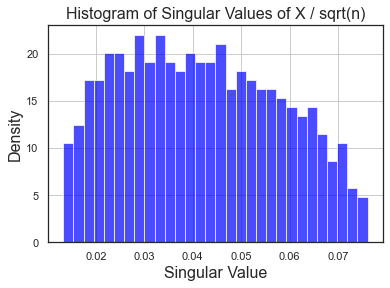

Numberical rank with threshold  0.001  is : 500


In [16]:
# Function to generate iid Gaussian matrix
def generate_iid_gaussian_matrix(d, n):
    variance = 1 / np.sqrt(d)
    return np.random.normal(loc=0, scale=variance, size=(d, n))

# Parameters
d = 500
n = 1000
threshold = 1e-3

# Generate random matrix X
X = generate_iid_gaussian_matrix(d, n)

C_0 = X / np.sqrt(n)

# Compute singular values of X / sqrt(n)
singular_values = np.linalg.svd(C_0, compute_uv=False)

# Count singular values smaller than threshold
count_singular_values = np.sum(singular_values > threshold)

# Plot histogram
plt.hist(singular_values, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Histogram of Singular Values of X / sqrt(n)')
plt.xlabel('Singular Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

print("Numberical rank with threshold ", threshold, " is :", count_singular_values)

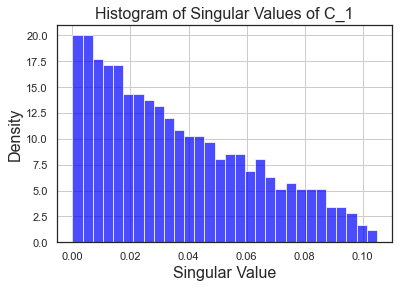

Numberical rank with threshold  0.001  is : 491


In [17]:
# Generate random matrix W_1
W_1 = generate_iid_gaussian_matrix(d, d)

# Compute C_1
C_1 = np.dot(W_1, C_0)

# Compute singular values of C_1
singular_values_C1 = np.linalg.svd(C_1, compute_uv=False)

# Count singular values smaller than threshold
count_singular_values_C1 = np.sum(singular_values_C1 > threshold)

# Plot histogram
plt.hist(singular_values_C1, bins=30, density=True, alpha=0.7, color='blue')
plt.title('Histogram of Singular Values of C_1')
plt.xlabel('Singular Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

print("Numberical rank with threshold ", threshold, " is :", count_singular_values_C1)

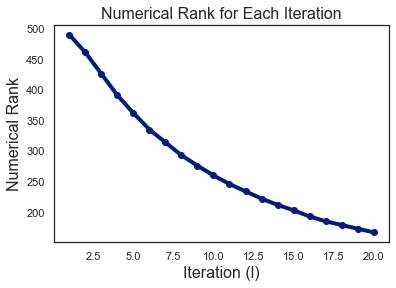

In [33]:

# Function to generate iid Gaussian matrix
def generate_iid_gaussian_matrix(d, n):
    variance = 1 / np.sqrt(d)
    return np.random.normal(loc=0, scale=variance, size=(d, n))

# Parameters
d = 500
n = 1000
threshold = 1e-3
L = 20  # Number of iterations

# Generate random matrix X
X = generate_iid_gaussian_matrix(d, n)

# Compute P_0
P_0 = X / np.sqrt(n)

# Initialize list to store numerical ranks
numerical_ranks = []

# Compute numerical rank for each P_l
P_l = P_0
for l in range(L):
    # Generate random matrix W_l
    W_l = generate_iid_gaussian_matrix(d, d)
    
    # Compute P_{l+1}
    P_l = np.dot(W_l, P_l)
    
    # Compute singular values of P_l
    singular_values_Pl = np.linalg.svd(P_l, compute_uv=False)
    
    # Count singular values larger than threshold
    count_large_singular_values_Pl = np.sum(singular_values_Pl > threshold)
    
    # Append numerical rank to the list
    numerical_ranks.append(count_large_singular_values_Pl)

# Plot numerical ranks for each l
plt.plot(range(1, L+1), numerical_ranks, marker='o')
plt.title('Numerical Rank for Each Iteration')
plt.xlabel('Iteration (l)')
plt.ylabel('Numerical Rank')
plt.grid(False)
plt.show()


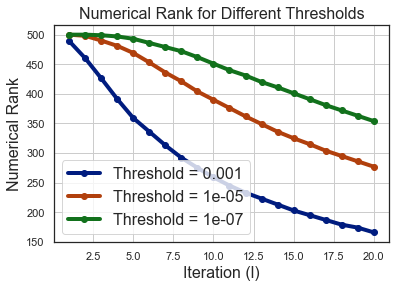

In [28]:

# Function to generate iid Gaussian matrix
def generate_iid_gaussian_matrix(d, n):
    variance = 1 / np.sqrt(d)
    return np.random.normal(loc=0, scale=variance, size=(d, n))

# Parameters
d = 500
n = 1000
thresholds = [1e-3, 1e-5, 1e-7]
L = 20  # Number of iterations

# Generate random matrix X
X = generate_iid_gaussian_matrix(d, n)

# Compute P_0
P_0 = X / np.sqrt(n)

# Initialize list to store numerical ranks for each threshold
numerical_ranks = {t: [] for t in thresholds}

# Compute numerical rank for each P_l and each threshold
for threshold in thresholds:
    P_l = P_0
    for l in range(L):
        # Generate random matrix W_l
        W_l = generate_iid_gaussian_matrix(d, d)
        
        # Compute P_{l+1}
        P_l = np.dot(W_l, P_l)
        
        # Compute singular values of P_l
        singular_values_Pl = np.linalg.svd(P_l, compute_uv=False)
        
        # Count singular values larger than threshold
        count_large_singular_values_Pl = np.sum(singular_values_Pl > threshold)
        
        # Append numerical rank to the list for the current threshold
        numerical_ranks[threshold].append(count_large_singular_values_Pl)

# Plot numerical ranks for each threshold
for threshold in thresholds:
    plt.plot(range(1, L+1), numerical_ranks[threshold], marker='o', label=f'Threshold = {threshold}')

plt.title('Numerical Rank for Different Thresholds')
plt.xlabel('Iteration (l)')
plt.ylabel('Numerical Rank')
plt.legend()
plt.grid(True)
plt.show()


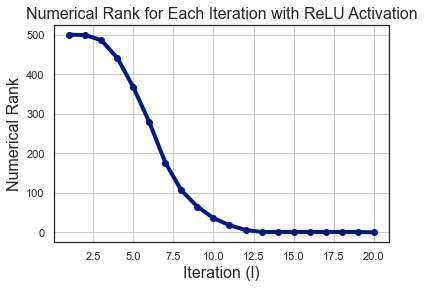

In [32]:
# Function to generate iid Gaussian matrix
def generate_iid_gaussian_matrix(d, n):
    variance = 1 / np.sqrt(d)
    return np.random.normal(loc=0, scale=variance, size=(d, n))

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Parameters
d = 500
n = 1000
threshold = 1e-3
L = 20  # Number of iterations

# Generate random matrix X
X = generate_iid_gaussian_matrix(d, n)

# Compute P_0
P_0 = X / np.sqrt(n)

# Initialize list to store numerical ranks
numerical_ranks = []

# Compute numerical rank for each P_l
P_l = P_0
for l in range(L):
    # Generate random matrix W_l
    W_l = generate_iid_gaussian_matrix(d, d)
    
    # Compute P_{l+1}
    P_l = relu(np.dot(W_l, P_l))
    
    # Compute singular values of P_l
    singular_values_Pl = np.linalg.svd(P_l, compute_uv=False)
    
    # Count singular values larger than threshold
    count_large_singular_values_Pl = np.sum(singular_values_Pl > threshold)
    
    # Append numerical rank to the list
    numerical_ranks.append(count_large_singular_values_Pl)

# Plot numerical ranks for each l
plt.plot(range(1, L+1), numerical_ranks, marker='o')
plt.title('Numerical Rank for Each Iteration with ReLU Activation')
plt.xlabel('Iteration (l)')
plt.ylabel('Numerical Rank')
plt.grid(True)
plt.show()


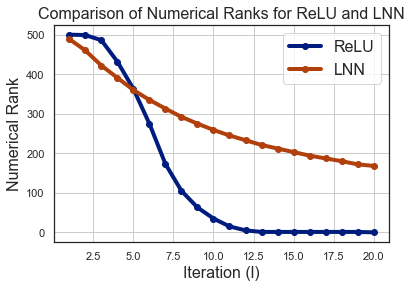

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Function to generate iid Gaussian matrix
def generate_iid_gaussian_matrix(d, n):
    variance = 1 / np.sqrt(d)
    return np.random.normal(loc=0, scale=variance, size=(d, n))

# ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Parameters
d = 500
n = 1000
threshold = 1e-3
L = 20  # Number of iterations

# Generate random matrix X
X = generate_iid_gaussian_matrix(d, n)

# Compute P_0 and S_0
P_0 = X / np.sqrt(n)
S_0 = X / np.sqrt(n)

# Initialize lists to store numerical ranks
numerical_ranks_P = []
numerical_ranks_S = []

# Compute numerical rank for each P_l and S_l
P_l = P_0
S_l = S_0
for l in range(L):
    # Generate random matrix W_l
    W_l = generate_iid_gaussian_matrix(d, d)
    
    # Compute P_{l+1} and S_{l+1}
    P_l = relu(np.dot(W_l, P_l))
    S_l = np.dot(W_l, S_l)
    
    # Compute singular values of P_l and S_l
    singular_values_Pl = np.linalg.svd(P_l, compute_uv=False)
    singular_values_Sl = np.linalg.svd(S_l, compute_uv=False)
    
    # Count singular values larger than threshold for P_l and S_l
    count_large_singular_values_Pl = np.sum(singular_values_Pl > threshold)
    count_large_singular_values_Sl = np.sum(singular_values_Sl > threshold)
    
    # Append numerical ranks to the lists
    numerical_ranks_P.append(count_large_singular_values_Pl)
    numerical_ranks_S.append(count_large_singular_values_Sl)

# Plot numerical ranks for each l
plt.plot(range(1, L+1), numerical_ranks_P, marker='o', label='ReLU')
plt.plot(range(1, L+1), numerical_ranks_S, marker='o', label='LNN')
plt.title('Comparison of Numerical Ranks for ReLU and LNN')
plt.xlabel('Iteration (l)')
plt.ylabel('Numerical Rank')
plt.legend()
plt.grid(True)
plt.show()
